In [3]:
import torch 
import torch.nn as nn
import torchmetrics
from torch.utils.data import Dataset
import pandas as pd

In [4]:
import torch.nn as nn 
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

BATCH_SIZE = 32
LR = 0.001
CLASSES = 2

TRAIN_VAL_TEST_SPLIT = [0.9, 0.05, 0.05]

EPOCHS = 40
LOSS_FUNCTION =nn.BCEWithLogitsLoss()#pos_weight=torch.tensor([10.0])

AUGMENT = True
SAVE_BEST_MODEL = True
IS_MULTICLASS = True if CLASSES > 2 else False
NUM_OF_WORKERS = 0

In [5]:

class SteelPlateDataset(Dataset):

    def __init__(self, dataset_path):
        super().__init__()
        self.path = dataset_path
        self.df = pd.read_csv(self.path)

        self.features = self.df.drop(["Class", *("V28 V29 V30 V31 V32 V33".split(" "))] ,axis= 1).values.tolist()
        self.labels = self.df["Class"].to_list()

    def __getitem__(self, index):

        return torch.tensor(self.features[index]), torch.tensor(self.labels[index])
    def __len__(self):
        return len(self.labels)
        



In [6]:



dataset = SteelPlateDataset("data/norm_data.csv")

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, TRAIN_VAL_TEST_SPLIT)


In [7]:
len(dataset.features[0])

27

In [8]:
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Default shuffling for training
    num_workers=NUM_OF_WORKERS
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for validation
    num_workers=NUM_OF_WORKERS
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for test
    num_workers=NUM_OF_WORKERS
)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1747
Validation dataset size: 97
Test dataset size: 97


In [10]:
from torchmetrics.classification import Accuracy, Precision
from torch.optim.lr_scheduler import ReduceLROnPlateau


class MyModel(nn.Module):
    def __init__(self, input_size,lr=0.001, loss_fn=nn.BCELoss(), num_classes=2):
        super().__init__()
        self.accuracy = Accuracy(task="binary", num_classes=num_classes)
        self.precision = Precision(task="multiclass", num_classes=num_classes, average=None)
        self.loss_fn = loss_fn


        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes if num_classes > 2 else 1)
        )
        self.to(device_name)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=10
        )

    def forward(self, x):
        return self.model(x)
        
        
    def evaluate(self, dataloader):
        self.eval()
        eval_loss = 0
        

        with torch.no_grad():
            for batch in dataloader:

                x = batch[0].to(device_name)
                y = batch[1].to(device_name)

                output = self.forward(x)
                output = torch.sigmoid(output).squeeze(1)
                y = y.float()

                
                    
                loss = self.loss_fn(output, y)
 
                self.accuracy(output, y)
                self.precision(output, y)
              
          
                eval_loss += loss.item()

        self.train()
        return (eval_loss/len(dataloader), self.accuracy.compute(), self.precision.compute())
    
        
    def fit(self, train_dataloader, val_dataloader, epochs=10):
        self.train()
        best_val_loss = 9999

     
      
        for i in range(0,epochs):
           
            self.accuracy.reset()
            epoch_loss = 0
            for batch in train_dataloader:

                x = batch[0].to(device_name)
                y = batch[1].to(device_name)
              

                output = self.forward(x)
                output = torch.sigmoid(output).squeeze(1)
                y = y.float()
                
            
                
                loss = self.loss_fn(output, y)

               
                self.accuracy(output, y)
                self.precision(output, y)

                epoch_loss += loss.item()

                self.zero_grad()
                loss.backward()
                self.optimizer.step()


            epoch_loss/=len(train_dataloader)
           
            epoch_acc = self.accuracy.compute()
            epoch_precision = self.precision.compute()

       

            val_loss, val_acc, val_precision = self.evaluate(val_dataloader)
            if best_val_loss > val_loss:
                best_val_loss = val_loss
                torch.save(self.state_dict(), "best-model-by-loss.pth")

         

            self.scheduler.step(val_loss)
            #wandb.log({"epoch": i, "Train Loss": epoch_loss, "Train Acc":epoch_acc,"Train F1":epoch_f1, "Val Loss":val_loss, "Val Acc":val_acc,"Val F1":val_f1, "LR":self.optimizer.param_groups[0]['lr']})
            print(f"Epoch {i+1} Loss:{epoch_loss:.4f} Accuracy:{epoch_acc:.4f} Positive Precision:{epoch_precision[1].item():.4f} Negative Precision:{epoch_precision[0].item():.4f}  Val Loss:{val_loss:.4f} Val Accuracy:{val_acc:.4f} Val Positive Precision:{val_precision[1].item():.4f} Val Negative Precision:{val_precision[0].item():.4f} LR = {self.optimizer.param_groups[0]['lr']}")
        #wandb.finish()
        


In [11]:
model = MyModel(input_size=27,num_classes=CLASSES, loss_fn=LOSS_FUNCTION, lr=LR)

In [12]:
model.fit(train_dataloader, val_dataloader, epochs=200)

Epoch 1 Loss:0.7019 Accuracy:0.6497 Positive Precision:0.0000 Negative Precision:0.6520  Val Loss:0.6932 Val Accuracy:0.6491 Val Positive Precision:0.0000 Val Negative Precision:0.6513 LR = 0.001
Epoch 2 Loss:0.6932 Accuracy:0.6520 Positive Precision:0.0000 Negative Precision:0.6516  Val Loss:0.6932 Val Accuracy:0.6513 Val Positive Precision:0.0000 Val Negative Precision:0.6513 LR = 0.001
Epoch 3 Loss:0.6931 Accuracy:0.6520 Positive Precision:0.0000 Negative Precision:0.6515  Val Loss:0.6932 Val Accuracy:0.6513 Val Positive Precision:0.0000 Val Negative Precision:0.6513 LR = 0.001
Epoch 4 Loss:0.6931 Accuracy:0.6520 Positive Precision:0.0000 Negative Precision:0.6515  Val Loss:0.6932 Val Accuracy:0.6513 Val Positive Precision:0.0000 Val Negative Precision:0.6513 LR = 0.001
Epoch 5 Loss:0.6931 Accuracy:0.6520 Positive Precision:0.0000 Negative Precision:0.6514  Val Loss:0.6931 Val Accuracy:0.6513 Val Positive Precision:0.0000 Val Negative Precision:0.6513 LR = 0.001
Epoch 6 Loss:0.6931 

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (each pixel has an integer class label)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=False,  # Use sampler instead of shuffle
    num_workers=NUM_OF_WORKERS
)

features, ground_truth = next(iter(val_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)
predictions = (torch.sigmoid(predictions) > 0.5).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()





[[59  3]
 [25 10]]


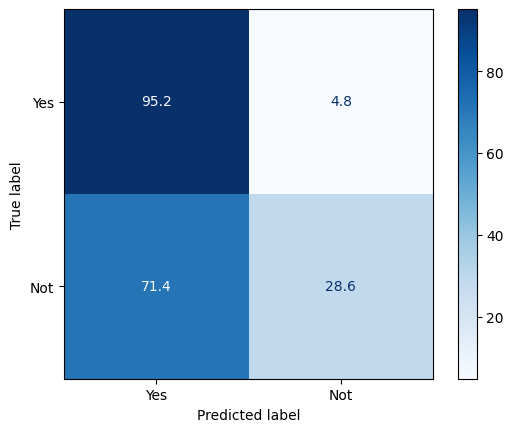

In [14]:
cm = confusion_matrix(y_true, y_pred)
print(cm)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Yes", "Not"])

disp.plot(cmap='Blues', values_format='.1f')



   


In [15]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,  # Use sampler instead of shuffle
    num_workers=NUM_OF_WORKERS
)

test_loss, test_acc, test_precision = model.evaluate(test_dataloader)


features, ground_truth = next(iter(test_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)
predictions = (torch.sigmoid(predictions) > 0.5).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()

[[65  2]
 [18 12]]


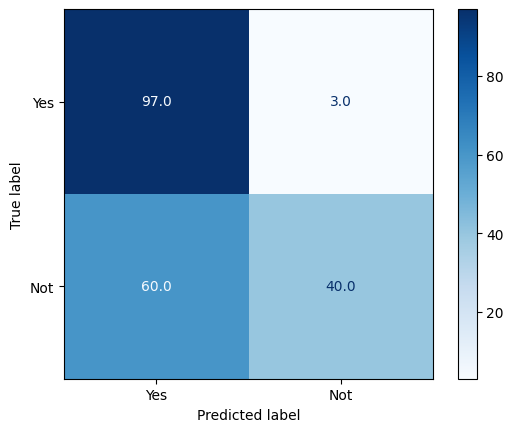

In [16]:
cm = confusion_matrix(y_true, y_pred)
print(cm)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Yes", "Not"])

disp.plot(cmap='Blues', values_format='.1f')



   
